## Logistic Regression model to predict if rating will be >= 4

In [1]:
# Import dependencies
import pandas as pd
import numpy as np

import pymssql

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# Connect to the pymssql database server
con = pymssql.connect(server='rubinasqlserver.database.windows.net',
                      user='group4admin',
                      password='group4@pwd',
                      database='rubinasql',
                      timeout=0,
                      login_timeout=60,
                      charset='UTF-8',
                      as_dict=True,
                      appname=None,
                      port='1433')

cursor = con.cursor()

query = "SELECT * FROM dbo.SF_Data_geojson_full"

cursor.execute(query)

data = cursor.fetchall()

for item in data:
    print(item)
    
con.close()

{'Name': 'Marufuku Ramen', 'Review_count': 4122, 'Category': 'Ramen', 'Rating': 4.5, 'Price': '$$', 'Latitude': 37.785118103027344, 'Longitude': -122.4320068359375, 'Review': '[\'Long long overdue review, but I loved this place. The line was literally booty, so me and my friends went half an hour before opening, and sat by a nearby...\', "The food was amazing! I got the marufuku bites and the hakata tonkatsu, they were so good! The broth was the best I\'ve ever had, highly recommend!", \'Located inside a shopping mall, this is a perfect lunch spot. Come early and put your name down on the list and walk around the mall area to get some...\']', 'Rating_binary': 4.5, 'Neighborhood': 'Japantown'}
{'Name': 'Fog Harbor Fish House', 'Review_count': 8324, 'Category': 'Seafood', 'Rating': 4.5, 'Price': '$$', 'Latitude': 37.80898666381836, 'Longitude': -122.41029357910156, 'Review': '[\'Great food and not a long wait.  Perfect on a cool early afternoon.  Nice wait staff and right on the water.\'

In [3]:
sf_original_df = pd.DataFrame(data)
sf_original_df

,Name,Review_count,Category,Rating,Price,Latitude,Longitude,Review,Rating_binary,Neighborhood
0,Marufuku Ramen,4122,Ramen,4.5,$$,37.785118,-122.432007,"['Long long overdue review, but I loved this p...",4.5,Japantown
1,Fog Harbor Fish House,8324,Seafood,4.5,$$,37.808987,-122.410294,['Great food and not a long wait. Perfect on ...,4.5,Fishermans Wharf
2,Dumpling House,360,Dim Sum,4.5,$$,37.763554,-122.432762,"[""Love coming here - I've gotten so many of th...",4.5,Castro
3,Starbelly,2115,Comfort Food,4.0,$$,37.764019,-122.432533,['Starbelly has been one of my go to comfort r...,4.0,Castro
4,Bottega,379,Italian,4.5,$$,37.754719,-122.421204,['What a great place to grab lunch/dinner with...,4.5,Mission
...,...,...,...,...,...,...,...,...,...,...
619,LaoTable,1339,Laotian,4.0,$$,37.787514,-122.398720,None,4.0,South of Market
620,Wooly Pig,777,Sandwiches,4.5,$$,37.760662,-122.388420,None,4.5,Dogpatch
621,Boudin,4161,Bakeries,4.0,$$,37.808506,-122.414902,None,4.0,Fishermans Wharf
622,Tara Indian Cuisine,421,Indian,4.0,$$,37.765408,-122.431229,None,4.0,Castro


## Exploratory Data Analysis

In [4]:
# View a list of all of the columns
sf_original_df.columns

Index(['Name', 'Review_count', 'Category', 'Rating', 'Price', 'Latitude',
       'Longitude', 'Review', 'Rating_binary', 'Neighborhood'],
      dtype='object')

In [5]:
# Check column data types
sf_original_df.dtypes

Name              object
Review_count       int64
Category          object
Rating           float64
Price             object
Latitude         float64
Longitude        float64
Review            object
Rating_binary    float64
Neighborhood      object
dtype: object

In [6]:
# Value_counts the Neighborhood column for preprocessing
neighborhood_counts = sf_original_df.Neighborhood.value_counts()
neighborhood_counts

Mission               47
Inner Richmond        38
Castro                27
Inner Sunset          27
South of Market       27
                      ..
Portola                1
Central Waterfront     1
Silver Terrace         1
Eureka Valley          1
Parnassus Heights      1
Name: Neighborhood, Length: 71, dtype: int64

In [7]:
neighborhood_counts[:30]

Mission                  47
Inner Richmond           38
Castro                   27
Inner Sunset             27
South of Market          27
Outer Richmond           25
Mission Dolores          18
Lower Nob Hill           17
Lower Haight             17
Outer Sunset             16
Haight Ashbury           16
Japantown                15
Financial District       15
Panhandle                15
North Beach              14
Marina                   14
Lower Pacific Heights    13
Polk Gulch               13
Duboce Triangle          12
Noe Valley               12
Tenderloin               11
Pacific Heights          11
Alamo Square             10
Fishermans Wharf          9
Hayes Valley              9
Presidio Heights          9
Western Addition          9
Chinatown                 9
Civic Center              9
Union Street              9
Name: Neighborhood, dtype: int64

<AxesSubplot:ylabel='Density'>

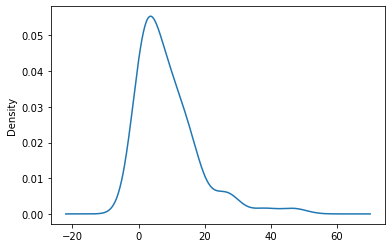

In [8]:
# Visualize the value counts of Neighborhood
neighborhood_counts.plot.density()

In [9]:
# Put the neighborhoods in a list.
neighborhood_list = sf_original_df.Neighborhood.tolist()
neighborhood_list

['Japantown',
 'Fishermans Wharf',
 'Castro',
 'Castro',
 'Mission',
 'Inner Sunset',
 'Cole Valley',
 'North Beach',
 'Castro',
 'Downtown / Union Square',
 'Fishermans Wharf',
 'Pacific Heights',
 'Mission',
 'Lower Haight',
 'Cathedral Hill',
 'Civic Center',
 'Inner Sunset',
 'Mission Dolores',
 'Duboce Triangle',
 'Castro',
 'Japantown',
 'Outer Richmond',
 'Haight Ashbury',
 'Castro',
 'Outer Sunset',
 'Inner Richmond',
 'Outer Richmond',
 'Alamo Square',
 'Alamo Square',
 'Lower Pacific Heights',
 'Parkside',
 'Union Street',
 'Castro',
 'Japantown',
 'Panhandle',
 'Outer Richmond',
 'Japantown',
 'Outer Richmond',
 'North Beach',
 'Inner Richmond',
 'Panhandle',
 'Eureka Valley',
 'Inner Richmond',
 'Inner Sunset',
 'Haight Ashbury',
 'Pacific Heights',
 'Western Addition',
 'South of Market',
 'Castro',
 'Castro',
 'Cole Valley',
 'Inner Sunset',
 'Pacific Heights',
 'Noe Valley',
 'Presidio Heights',
 'Panhandle',
 'Inner Sunset',
 'Lower Haight',
 'Inner Richmond',
 'Inner S

In [10]:
# Value_counts the Category column for preprocessing
category_counts = sf_original_df.Category.value_counts()
category_counts

American (New)        45
Italian               40
Breakfast & Brunch    35
Japanese              32
Vietnamese            26
                      ..
Uzbek                  1
Halal                  1
Gluten-Free            1
Kebab                  1
Laotian                1
Name: Category, Length: 99, dtype: int64

In [11]:
category_counts[:40]

American (New)            45
Italian                   40
Breakfast & Brunch        35
Japanese                  32
Vietnamese                26
Mexican                   25
Seafood                   23
Korean                    23
Chinese                   20
Sushi Bars                19
Mediterranean             19
Pizza                     17
Coffee & Tea              14
American (Traditional)    14
Bakeries                  14
Ramen                     13
Thai                      11
Dim Sum                   10
Sandwiches                 9
Burgers                    9
Cocktail Bars              9
Noodles                    8
Wine Bars                  8
Latin American             8
Tacos                      7
Middle Eastern             7
Burmese                    7
Asian Fusion               6
French                     6
Spanish                    6
Cafes                      6
Greek                      5
Indian                     5
Chicken Wings              4
German        

<AxesSubplot:ylabel='Density'>

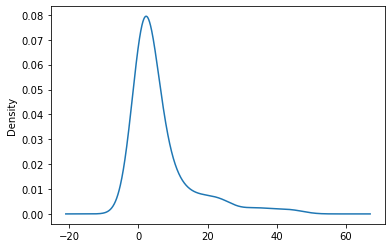

In [12]:
# Visualize the value counts of Category
category_counts.plot.density()

In [13]:
# Put the categories in a list.
cat_list = sf_original_df.Category.tolist()
cat_list

['Ramen',
 'Seafood',
 'Dim Sum',
 'Comfort Food',
 'Italian',
 'Asian Fusion',
 'Arabic',
 'Seafood',
 'Dim Sum',
 'Thai',
 'Korean',
 'Cocktail Bars',
 'Thai',
 'Korean',
 'Sandwiches',
 'Dim Sum',
 'Chinese',
 'Breakfast & Brunch',
 'Breakfast & Brunch',
 'American (New)',
 'Seafood',
 'Korean',
 'Latin American',
 'Vietnamese',
 'Seafood',
 'Bakeries',
 'Pizza',
 'American (New)',
 'Cocktail Bars',
 'American (Traditional)',
 'Chinese',
 'Italian',
 'Mexican',
 'Japanese',
 'Mediterranean',
 'Italian',
 'Korean',
 'Mediterranean',
 'Seafood',
 'Chinese',
 'Mexican',
 'Dim Sum',
 'Burmese',
 'Vietnamese',
 'Caribbean',
 'Coffee & Tea',
 'Breakfast & Brunch',
 'Japanese',
 'Korean',
 'Brazilian',
 'Breakfast & Brunch',
 'Korean',
 'Mediterranean',
 'Mediterranean',
 'Mediterranean',
 'Italian',
 'Korean',
 'Thai',
 'Hawaiian',
 'Mediterranean',
 'Korean',
 'Ramen',
 'Italian',
 'Taiwanese',
 'Izakaya',
 'Persian/Iranian',
 'Italian',
 'Diners',
 'Breakfast & Brunch',
 'Greek',
 'Span

In [14]:
# Value_counts the Price column for preprocessing
price_counts = sf_original_df.Price.value_counts()
print(price_counts)

$$      501
$$$      67
$        35
$$$$     21
Name: Price, dtype: int64


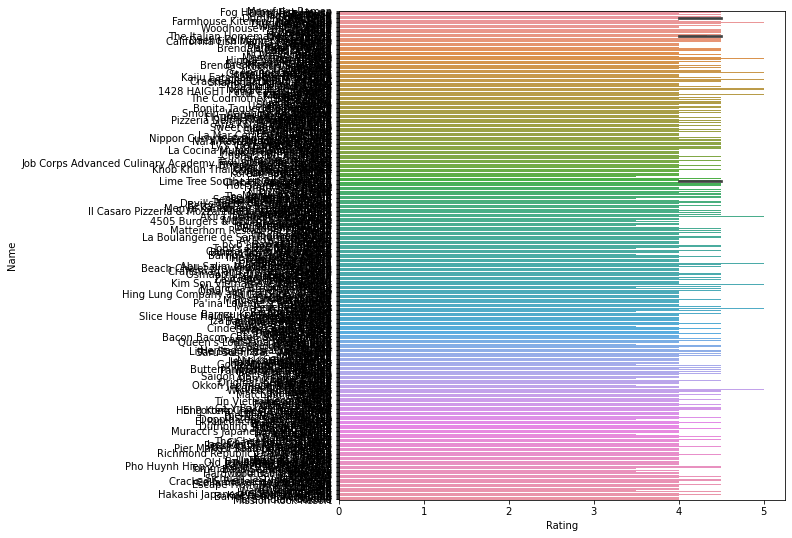

In [15]:
# Plot the 'Rating' and the 'Name' columns in a barplot.
fig, ax = plt.subplots(figsize=(8,9))
sns.barplot(x="Rating", y="Name", data=sf_original_df, ax=ax);
plt.show()

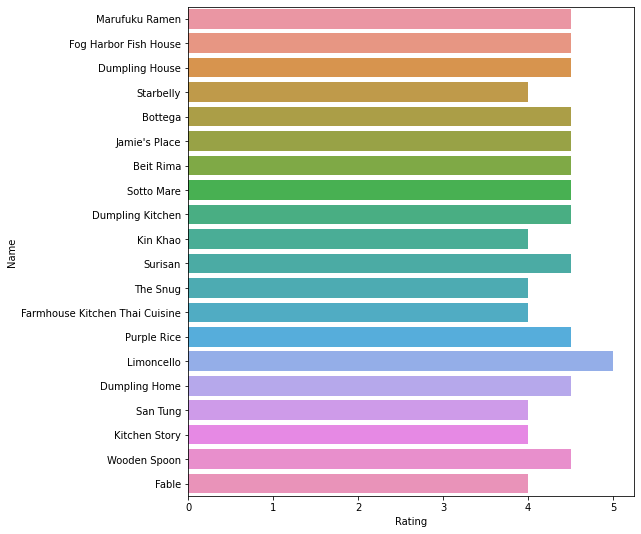

In [16]:
# Plot the 'Rating' and the 'Name' columns in a barplot.
fig, ax = plt.subplots(figsize=(8,9))
sns.barplot(x="Rating", y="Name", data=sf_original_df[:20], ax=ax);
plt.show()

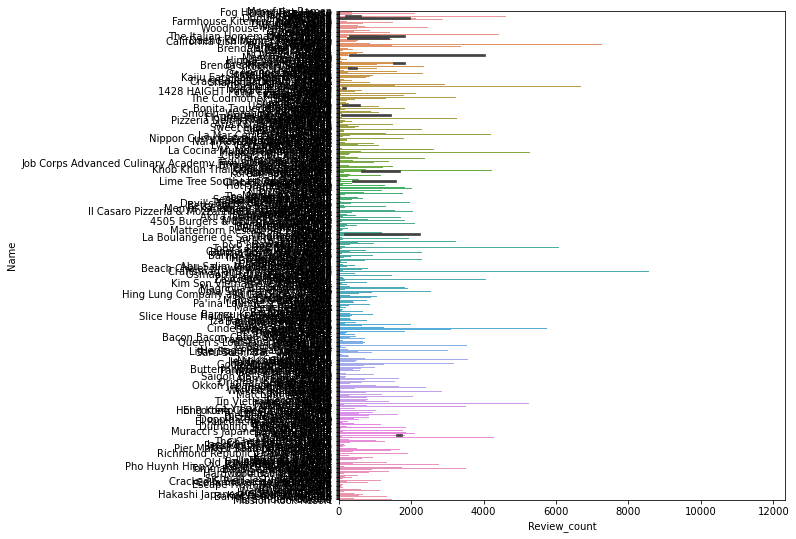

In [17]:
# Plot the 'Review_count' and the 'Name' columns in a barplot.
fig, ax = plt.subplots(figsize=(8,9))
sns.barplot(x="Review_count", y="Name", data=sf_original_df, ax=ax);
plt.show()

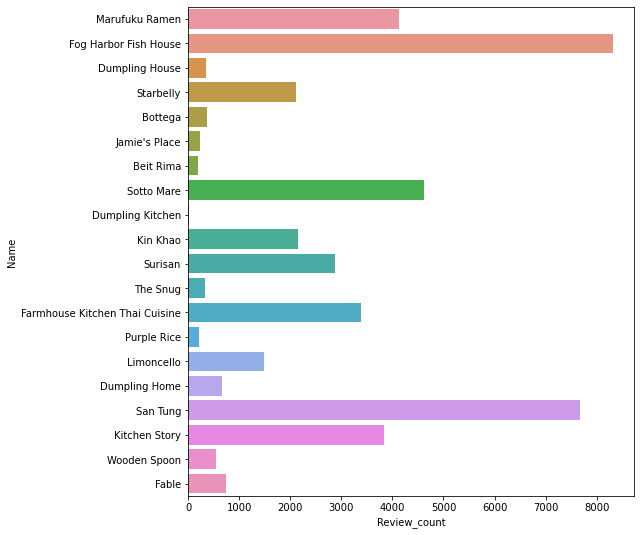

In [18]:
# Plot the 'Review_count' and the 'Name' columns in a barplot.
fig, ax = plt.subplots(figsize=(8,9))
sns.barplot(x="Review_count", y="Name", data=sf_original_df[:20], ax=ax);
plt.show()

C:\Users\Michelle\anaconda3\envs\mlenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


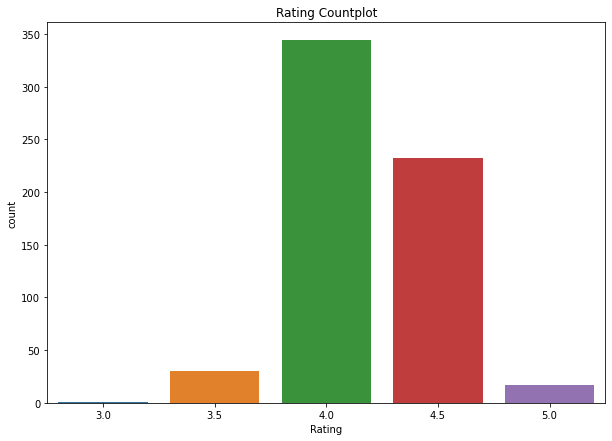

In [19]:
# Plot the 'Rating' in a countplot.
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(sf_original_df["Rating"], ax=ax)
plt.title("Rating Countplot")
plt.show()

## Preprocess the data

In [20]:
# Drop columns that are not relevant to the analysis / will confuse the model
sf_df = sf_original_df.drop(columns=[
    'Name',
    'Latitude',
    'Longitude',
    'Review'
    ])
sf_df.head()

,Review_count,Category,Rating,Price,Rating_binary,Neighborhood
0,4122,Ramen,4.5,$$,4.5,Japantown
1,8324,Seafood,4.5,$$,4.5,Fishermans Wharf
2,360,Dim Sum,4.5,$$,4.5,Castro
3,2115,Comfort Food,4.0,$$,4.0,Castro
4,379,Italian,4.5,$$,4.5,Mission


In [21]:
# Convert 'Rating_binary' column to binary values
sf_df.loc[sf_df["Rating_binary"] < 4, "Rating_binary"] = 0
sf_df.loc[sf_df["Rating_binary"] >= 4, "Rating_binary"] = 1
sf_df

,Review_count,Category,Rating,Price,Rating_binary,Neighborhood
0,4122,Ramen,4.5,$$,1.0,Japantown
1,8324,Seafood,4.5,$$,1.0,Fishermans Wharf
2,360,Dim Sum,4.5,$$,1.0,Castro
3,2115,Comfort Food,4.0,$$,1.0,Castro
4,379,Italian,4.5,$$,1.0,Mission
...,...,...,...,...,...,...
619,1339,Laotian,4.0,$$,1.0,South of Market
620,777,Sandwiches,4.5,$$,1.0,Dogpatch
621,4161,Bakeries,4.0,$$,1.0,Fishermans Wharf
622,421,Indian,4.0,$$,1.0,Castro


In [22]:
# Convert 'Rating_binary' column from float64 to int to get rid of the decimal
sf_df = sf_df.astype({'Rating_binary' : int})
sf_df.head()

,Review_count,Category,Rating,Price,Rating_binary,Neighborhood
0,4122,Ramen,4.5,$$,1,Japantown
1,8324,Seafood,4.5,$$,1,Fishermans Wharf
2,360,Dim Sum,4.5,$$,1,Castro
3,2115,Comfort Food,4.0,$$,1,Castro
4,379,Italian,4.5,$$,1,Mission


In [23]:
# Drop the Rating column since the Rating binary column is what we will use for the analysis
sf_df = sf_df.drop(columns=['Rating'])
sf_df.head()

,Review_count,Category,Price,Rating_binary,Neighborhood
0,4122,Ramen,$$,1,Japantown
1,8324,Seafood,$$,1,Fishermans Wharf
2,360,Dim Sum,$$,1,Castro
3,2115,Comfort Food,$$,1,Castro
4,379,Italian,$$,1,Mission


In [24]:
# Convert 'Price' column to numeric values
sf_df.loc[sf_df["Price"] == "$", "Price"] = 1
sf_df.loc[sf_df["Price"] == "$$", "Price"] = 2
sf_df.loc[sf_df["Price"] == "$$$", "Price"] = 3
sf_df.loc[sf_df["Price"] == "$$$$", "Price"] = 4
sf_df

,Review_count,Category,Price,Rating_binary,Neighborhood
0,4122,Ramen,2,1,Japantown
1,8324,Seafood,2,1,Fishermans Wharf
2,360,Dim Sum,2,1,Castro
3,2115,Comfort Food,2,1,Castro
4,379,Italian,2,1,Mission
...,...,...,...,...,...
619,1339,Laotian,2,1,South of Market
620,777,Sandwiches,2,1,Dogpatch
621,4161,Bakeries,2,1,Fishermans Wharf
622,421,Indian,2,1,Castro


#### Bin the Category column

In [25]:
cat_counts = sf_df.Category.value_counts()
cat_counts[:40]

American (New)            45
Italian                   40
Breakfast & Brunch        35
Japanese                  32
Vietnamese                26
Mexican                   25
Seafood                   23
Korean                    23
Chinese                   20
Sushi Bars                19
Mediterranean             19
Pizza                     17
Coffee & Tea              14
American (Traditional)    14
Bakeries                  14
Ramen                     13
Thai                      11
Dim Sum                   10
Sandwiches                 9
Burgers                    9
Cocktail Bars              9
Noodles                    8
Wine Bars                  8
Latin American             8
Tacos                      7
Middle Eastern             7
Burmese                    7
Asian Fusion               6
French                     6
Spanish                    6
Cafes                      6
Greek                      5
Indian                     5
Chicken Wings              4
German        

In [26]:
# Determine which values to replace if counts are less than ...?
replace_category = list(cat_counts[cat_counts <= 4].index)

# Replace in dataframe
for cat in replace_category:
    sf_df.Category = sf_df.Category.replace(cat,"Other")
    
# Check to make sure binning was successful
cat_counts2 = sf_df.Category.value_counts()
cat_counts2[:40]

Other                     118
American (New)             45
Italian                    40
Breakfast & Brunch         35
Japanese                   32
Vietnamese                 26
Mexican                    25
Korean                     23
Seafood                    23
Chinese                    20
Sushi Bars                 19
Mediterranean              19
Pizza                      17
American (Traditional)     14
Coffee & Tea               14
Bakeries                   14
Ramen                      13
Thai                       11
Dim Sum                    10
Sandwiches                  9
Cocktail Bars               9
Burgers                     9
Latin American              8
Wine Bars                   8
Noodles                     8
Tacos                       7
Burmese                     7
Middle Eastern              7
Spanish                     6
Cafes                       6
Asian Fusion                6
French                      6
Greek                       5
Indian    

In [27]:
# Determine which values to replace if counts are less than ...?
replace_category2 = list(cat_counts2[(cat_counts2 <= 10) & (cat_counts2 > 5)].index)

# Replace in dataframe
for cat in replace_category2:
    sf_df.Category = sf_df.Category.replace(cat,"Other")
    
# Check to make sure binning was successful
cat_counts3 = sf_df.Category.value_counts()
cat_counts3[:20]

Other                     224
American (New)             45
Italian                    40
Breakfast & Brunch         35
Japanese                   32
Vietnamese                 26
Mexican                    25
Korean                     23
Seafood                    23
Chinese                    20
Sushi Bars                 19
Mediterranean              19
Pizza                      17
Coffee & Tea               14
Bakeries                   14
American (Traditional)     14
Ramen                      13
Thai                       11
Greek                       5
Indian                      5
Name: Category, dtype: int64

In [28]:
sf_df

,Review_count,Category,Price,Rating_binary,Neighborhood
0,4122,Ramen,2,1,Japantown
1,8324,Seafood,2,1,Fishermans Wharf
2,360,Other,2,1,Castro
3,2115,Other,2,1,Castro
4,379,Italian,2,1,Mission
...,...,...,...,...,...
619,1339,Other,2,1,South of Market
620,777,Other,2,1,Dogpatch
621,4161,Bakeries,2,1,Fishermans Wharf
622,421,Indian,2,1,Castro


#### Bin the Neighborhood column

In [ ]:
# # Determine which values to replace if counts are less than ...?
# replace_application = list(app_type_counts[app_type_counts < 200].index)

# # Replace in dataframe
# for app in replace_application:
#     application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# # Check to make sure binning was successful
# application_df.APPLICATION_TYPE.value_counts()

### Define variables and Split the data into train and test sets

In [21]:
# Create our features
X = sf_df.drop(columns="Rating_binary")
X = pd.get_dummies(X)


# Create our target
y = sf_df["Rating_binary"]

In [22]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Check the shape of X_train
X_train.shape

(468, 175)

In [23]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Create, Train, and Evaluate the model

In [24]:
# Define the logistic regression model
log_classifier = LogisticRegression(solver="lbfgs", max_iter=200, random_state=1)


# Train the model
log_classifier.fit(X_train,y_train)

# Evaluate the model
y_pred = log_classifier.predict(X_test)
print(f" Logistic Regression model accuracy: {accuracy_score(y_test,y_pred):.3f}")

results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(20)

 Logistic Regression model accuracy: 0.949


,Prediction,Actual
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1
6,1,0
7,1,1
8,1,1
9,1,1


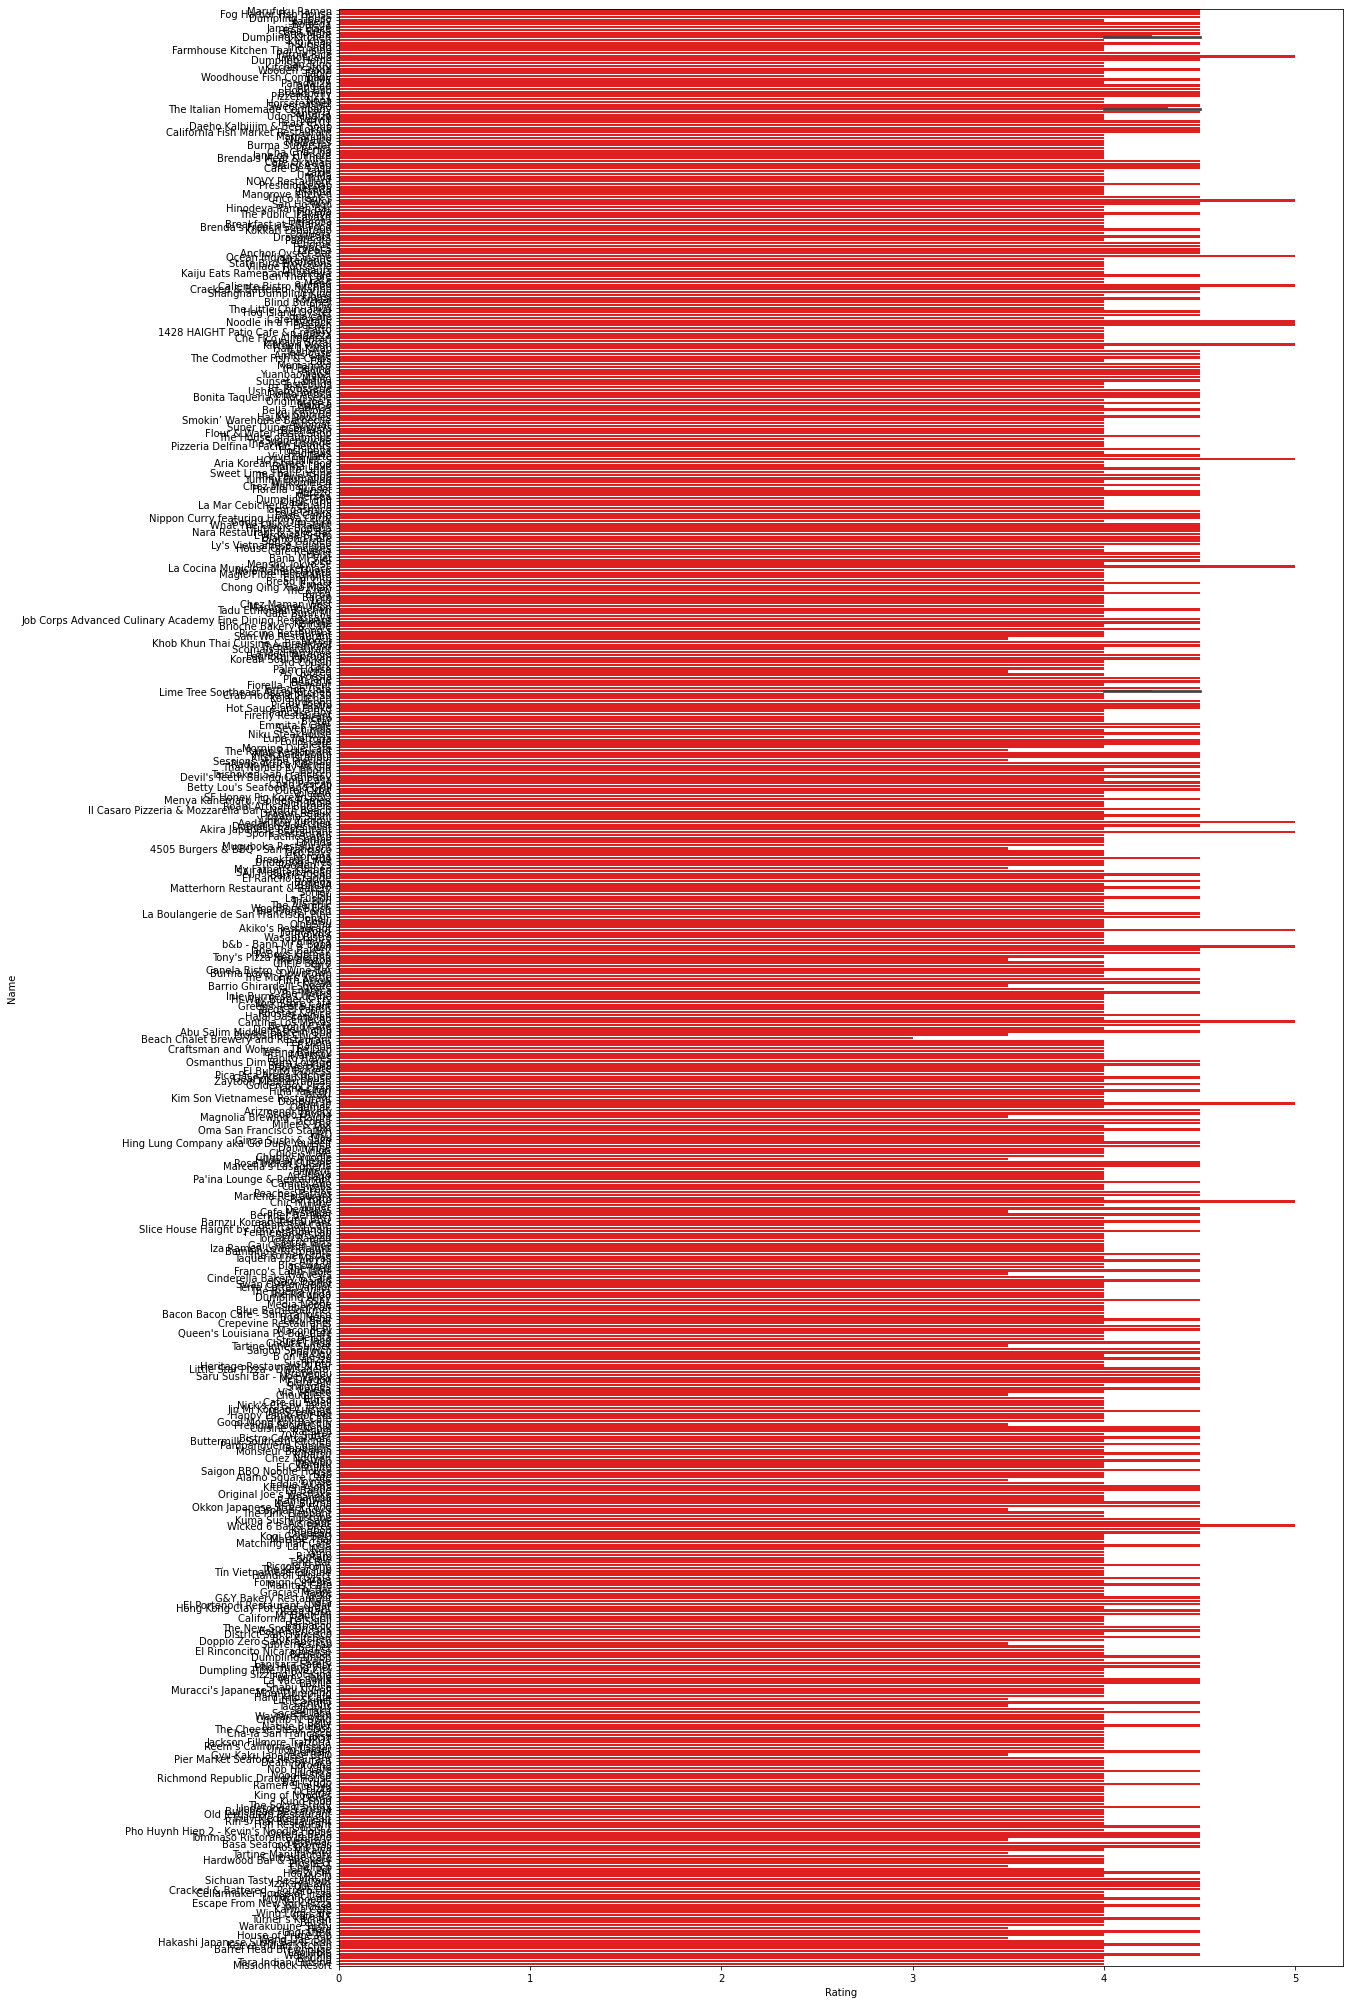

In [25]:
# Plot the data based on the model's predicted classes
# Define the colors
colors = ['red' if (x == 1) else 'blue' for x in results["Prediction"]]
        
fig, ax = plt.subplots(figsize=(18,36))
sns.barplot(x="Rating", y="Name", data=sf_original_df, palette=colors, ax=ax);
plt.show()

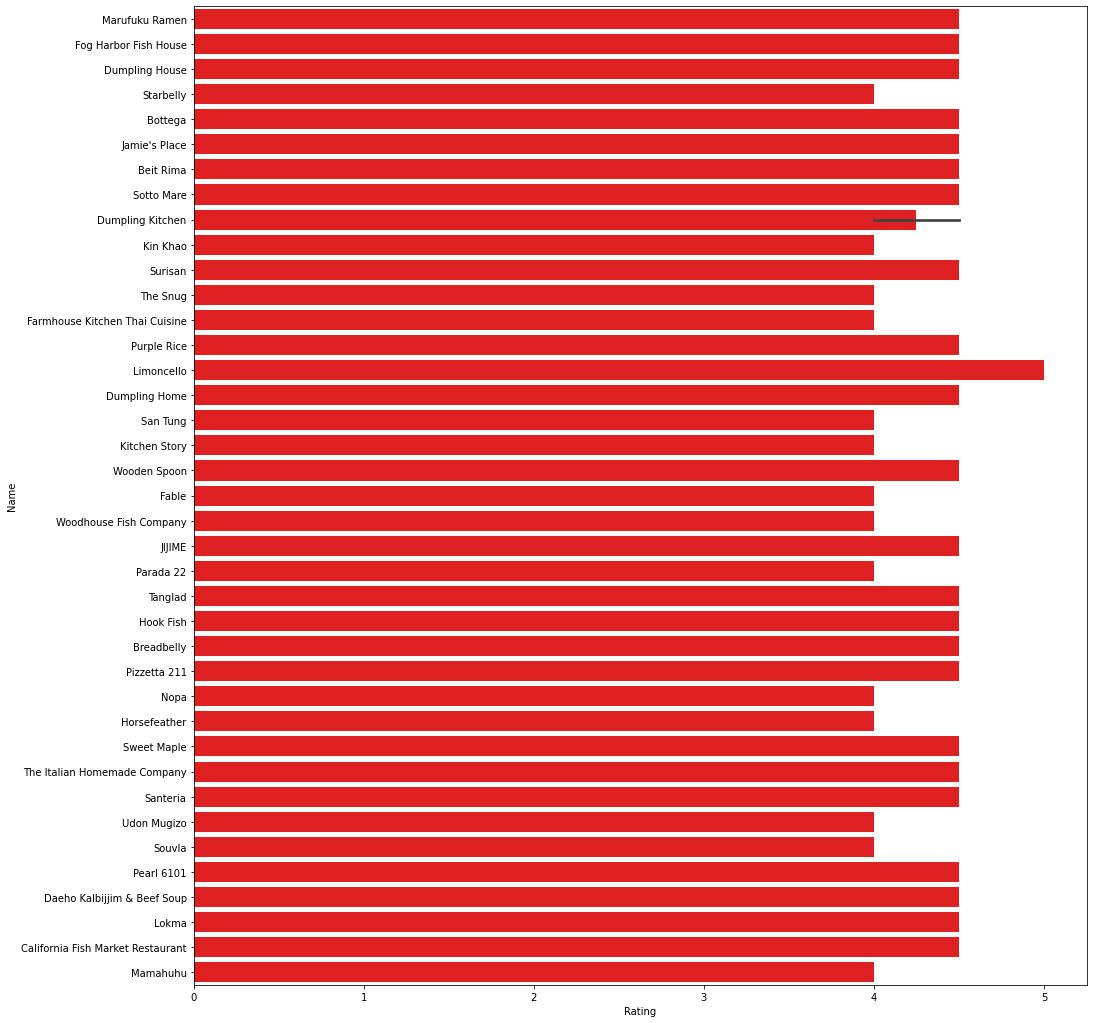

In [27]:
# Plot the data based on the model's predicted classes  
colors = ['red' if (x == 1) else 'blue' for x in results["Prediction"]]
fig, ax = plt.subplots(figsize=(16,18))
sns.barplot(x="Rating", y="Name", data=sf_original_df[:40], palette=colors, ax=ax);
plt.show()